In [34]:
import pandas as pd
import os
from tqdm.notebook import tqdm
import random
import shutil


def split_list(data, split_ratio=0.8):
    # Calculate the index to split the list
    split_index = int(len(data) * split_ratio)
    
    # Shuffle the list randomly
    random.shuffle(data)
    
    # Split the list based on the calculated index
    train_data = data[:split_index]
    test_data = data[split_index:]
    
    return train_data, test_data

def delete_files_in_directory(directory_path):
    # Get the list of files in the directory
    files = os.listdir(directory_path)

    # Iterate through the files and delete each one
    for file_name in tqdm(files):
        file_path = os.path.join(directory_path, file_name)
        try:
            if os.path.isfile(file_path):
                os.remove(file_path)
        except Exception as e:
            print(f"Error deleting {file_path}: {e}")
            
    shutil.rmtree(directory_path)

In [36]:
# Example usage:
directory_to_clear = '/kaggle/working/val'
delete_files_in_directory(directory_to_clear)
print('Done')

  0%|          | 0/4 [00:00<?, ?it/s]

Done


In [37]:
data_path = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset'

os.mkdir('/kaggle/working/train')
os.mkdir('/kaggle/working/val')

for class_name in os.listdir(data_path):
    if not os.path.isdir(os.path.join(data_path, class_name)):
        continue
    print('Processing: ', class_name)
    images_path = os.path.join(data_path, class_name, 'images')
    train_files, val_files = split_list(os.listdir(images_path), 0.8)
    train_ds = f'/kaggle/working/train/{class_name}'
    os.mkdir(train_ds)
    for file_name in tqdm(train_files):
        shutil.copy(os.path.join(images_path, file_name), os.path.join(train_ds, file_name))
    val_ds = f'/kaggle/working/val/{class_name}'
    os.mkdir(val_ds)
    for file_name in tqdm(val_files):
        shutil.copy(os.path.join(images_path, file_name), os.path.join(val_ds, file_name))

Processing:  Normal


  0%|          | 0/8153 [00:00<?, ?it/s]

  0%|          | 0/2039 [00:00<?, ?it/s]

Processing:  Lung_Opacity


  0%|          | 0/4809 [00:00<?, ?it/s]

  0%|          | 0/1203 [00:00<?, ?it/s]

Processing:  Viral Pneumonia


  0%|          | 0/1076 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

Processing:  COVID


  0%|          | 0/2892 [00:00<?, ?it/s]

  0%|          | 0/724 [00:00<?, ?it/s]

In [39]:
def find_minimum_files_count(directory):
    # Get the list of files in the directory
    files = os.listdir(directory)
    
    # Return the count of files in the directory
    return len(files)

def equalize_folders(file_root):
    # Get a list of all subdirectories in the given root directory
    subdirectories = [d for d in os.listdir(file_root) if os.path.isdir(os.path.join(file_root, d))]
    
    if not subdirectories:
        print("No subdirectories found.")
        return
    
    # Find the minimum number of files among all subdirectories
    min_files_count = min(find_minimum_files_count(os.path.join(file_root, subdir)) for subdir in subdirectories)
    
    # Equalize the number of files in each subdirectory
    for subdir in subdirectories:
        subdir_path = os.path.join(file_root, subdir)
        files = os.listdir(subdir_path)
        
        while len(files) > min_files_count:
            # Remove random file
            random_file = os.path.join(subdir_path, random.choice(files))
            os.remove(random_file)
            files.remove(os.path.basename(random_file))
            print(f"Deleted: {random_file}")

# Example usage:
# root_directory = 'path/to/root'
# equalize_folders(root_directory)


for sub in ['train', 'val']:
    sub_folder = f'/kaggle/working/{sub}'
    equalize_folders(sub_folder)

In [40]:
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [41]:
input_size = (128,128)
input_shape = (128, 128, 3)
base_dir = '/kaggle/working/'

In [42]:
train_gen = ImageDataGenerator(
    rescale=1./255
)
val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

In [43]:
train_data = train_gen.flow_from_directory(base_dir + 'train',target_size=input_size,seed=42)
val_data = val_gen.flow_from_directory(base_dir + 'val',target_size=input_size,seed=42)

Found 4304 images belonging to 4 classes.
Found 1076 images belonging to 4 classes.


In [44]:
vgg16 = VGG16(input_shape=input_shape, weights='imagenet', include_top=False)
for layer in vgg16.layers:
    layer.trainable = False
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [45]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and logs.get('accuracy') > 0.95:
            print("\nReached 95% accuracy so cancelling training!")
            self.model.stop_training = True

In [46]:
callbacks = myCallback()

output = Flatten()(vgg16.output)
output = Dense(500, activation='relu')(output)
output = Dense(100, activation='relu')(output)
output = Dropout(0.5)(output)
output = Dense(4, activation='softmax')(output)
model = Model(inputs=vgg16.input, outputs=output)
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [47]:
history = model.fit(train_data,
                    batch_size=32,
                    epochs=10,
                    validation_data=val_data,
                    callbacks = [callbacks])

Epoch 1/10
135/135 [==============================] - 15s 98ms/step - loss: 0.7813 - accuracy: 0.6928 - val_loss: 0.4388 - val_accuracy: 0.8364
Epoch 2/10
135/135 [==============================] - 13s 95ms/step - loss: 0.4607 - accuracy: 0.8262 - val_loss: 0.3766 - val_accuracy: 0.8569
Epoch 3/10
135/135 [==============================] - 12s 92ms/step - loss: 0.3868 - accuracy: 0.8620 - val_loss: 0.3909 - val_accuracy: 0.8504
Epoch 4/10
135/135 [==============================] - 13s 95ms/step - loss: 0.3331 - accuracy: 0.8813 - val_loss: 0.3393 - val_accuracy: 0.8652
Epoch 5/10
135/135 [==============================] - 13s 94ms/step - loss: 0.2825 - accuracy: 0.9020 - val_loss: 0.3442 - val_accuracy: 0.8745
Epoch 6/10
135/135 [==============================] - 13s 94ms/step - loss: 0.2316 - accuracy: 0.9175 - val_loss: 0.3150 - val_accuracy: 0.8792
Epoch 7/10
135/135 [==============================] - 13s 93ms/step - loss: 0.2128 - accuracy: 0.9210 - val_loss: 0.4389 - val_accuracy:

In [48]:
class_names = train_data.class_indices
class_names

{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}

1/1 [==============================] - 1s 686ms/step
Predicted class: COVID


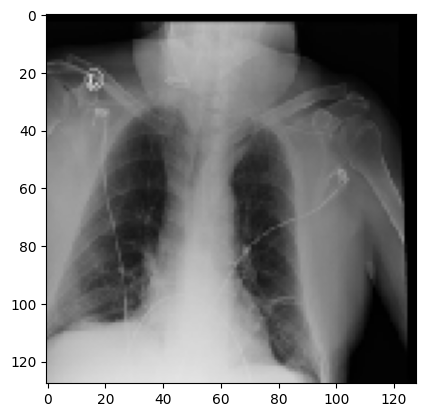

In [49]:
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt


path = '/kaggle/working/val/COVID/COVID-1226.png'
img = load_img(path, target_size=(128, 128))
x = img_to_array(img)
x /= 255
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
predictions = model.predict(images, batch_size=10)

# Get the predicted class index
predicted_class_index = np.argmax(predictions)

# Get the predicted class label from the 'gen' variable
predicted_class = list(class_names.keys())[list(class_names.values()).index(predicted_class_index)]

# Print the prediction
print("Predicted class:", predicted_class)
# print("Class probabilities:", predictions)

plt.imshow(img)
plt.show()